# Ensembling Decision Trees: Intuition, Math, and Methods

Ensembling is the process of combining multiple models to produce better performance than any single model alone. For decision trees, ensemble methods address the fact that a single tree can have high variance (overfitting) or high bias (underfitting). By aggregating multiple trees, we can achieve lower generalization error.

---

## 1. Why Ensemble Decision Trees?
A single decision tree partitions the feature space into regions and assigns predictions based on training data. However:
- **High variance:** Small changes in data can drastically alter the tree structure.
- **Overfitting risk:** Trees can perfectly fit training data but fail to generalize.

Ensembling mitigates these issues by averaging or weighting predictions from multiple trees, reducing variance and sometimes bias.

---

## 2. Bagging (Bootstrap Aggregating)
**Idea:** Train multiple trees on **different bootstrap samples** (random sampling with replacement) and average their predictions.

For classification, the ensemble predicts the class that gets the **majority vote**. For regression, it predicts the **mean** of outputs.

Mathematically, for regression:
$ \hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^{B} f_b(x) $
where $B$ is the number of trees, and $f_b$ is the $b$-th decision tree.

This reduces variance because averaging multiple noisy, unbiased estimators results in a more stable estimate.

![Bagging illustration](https://substackcdn.com/image/fetch/$s_!AUxY!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F3f696e70-2a88-40ae-b318-d81ec0e781f9_5950x2002.png)

---

## 3. Random Forests
A popular form of bagging where, in addition to bootstrap sampling, each split considers only a **random subset of features**.

This decorrelates the trees, because if one strong predictor dominates, every tree would otherwise look similar. The randomness forces trees to explore different patterns.

---

## 4. Boosting
**Idea:** Train trees sequentially, where each tree tries to correct the errors of the previous ensemble.

### AdaBoost (Adaptive Boosting)
Initially, all observations are weighted equally. After each tree is trained, misclassified points get **higher weights** so that the next tree focuses more on them.

The final prediction is a weighted sum of the individual trees:
$ F_M(x) = \sum_{m=1}^{M} \alpha_m f_m(x) $
where $\alpha_m$ depends on the accuracy of tree $m$.

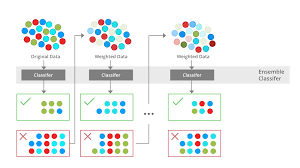

### Gradient Boosting
Instead of reweighting points, gradient boosting fits each tree to the **negative gradient** of the loss function (the residuals).

Algorithm steps:
1. Start with an initial model $F_0(x)$.
2. For each iteration $m$:
   - Compute pseudo-residuals: $r_{im} = -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}$
   - Fit a decision tree $h_m(x)$ to $r_{im}$.
   - Update model: $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$, where $\nu$ is the learning rate.


---

## 5. Stacking
**Idea:** Combine predictions from multiple different models (not necessarily all trees) using another model (meta-learner) to make the final prediction.

---

## 6. Summary Table

| Method       | Sampling Strategy         | Tree Correlation | Sequential? | Bias Effect | Variance Effect |
|--------------|---------------------------|------------------|-------------|-------------|-----------------|
| Bagging      | Bootstrap samples         | Moderate         | No          | Same        | Decreases       |
| Random Forest| Bootstrap + feature subsample | Low              | No          | Same        | Decreases       |
| AdaBoost     | Weighted samples          | Varies           | Yes         | Decreases   | May increase    |
| Gradient Boosting | Fits to residuals    | Varies           | Yes         | Decreases   | May increase    |

---

## 7. Practical Notes
- **Bagging/Random Forests** are better when the base model has high variance.
- **Boosting** is better when the base model has high bias.
- Choosing between them often depends on the dataset and the computational budget.



# Application to Bank Churn Dataset
- First, we will performs some basic EDA & feature analysis
- Second, we will create our own random forest algorithm, building off of our `decision_tree_from_scratch.ipynb` implementation of a decision tree. We will compare to Sklearn results
- Finally, we'll use Sklearn's GBM as a final comparison

| **Feature**                | **Description**                                                                    |
| -------------------------- | ---------------------------------------------------------------------------------- |
| **Surname**                | Customer’s last name (used for TF-IDF features).                                   |
| **CreditScore**            | Numeric credit score reflecting financial reliability.                             |
| **Age**                    | Customer’s age in years.                                                           |
| **Tenure**                 | Number of years the customer has been with the bank.                               |
| **Balance**                | Account balance in local currency.                                                 |
| **NumOfProducts**          | Number of bank products held (e.g., credit cards, loans).                          |
| **HasCrCard**              | Binary flag indicating if the customer has a credit card (1 = yes).                |
| **IsActiveMember**         | Binary indicator of whether the customer is active (1 = yes).                      |
| **EstimatedSalary**        | Estimated annual income.                                                           |
| **Exited**                 | Target variable — 1 if the customer left the bank, 0 otherwise.                    |
| **Surname_tfidf_0–4**      | Numerical text features from surname TF-IDF encoding (top 5 components).           |
| **France, Germany, Spain** | One-hot encoded country of residence.                                              |
| **Female, Male**           | One-hot encoded gender.                                                            |
| **Mem__no__Products**      | Engineered ratio or interaction between membership and products.                   |
| **Cred_Bal_Sal**           | Combined feature capturing relationship between credit score, balance, and salary. |
| **Bal_sal**                | Ratio of balance to salary.                                                        |
| **Tenure_Age**             | Interaction term between tenure and age.                                           |
| **Age_Tenure_product**     | Product of age and tenure capturing long-term engagement.                          |


In [5]:
# Standard imports
import sys
sys.path.append("/Users/rykerdolese/Documents/INDE 577/Data-Science-and-Machine-Learning/src")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# my package imports
from mlpackage.preprocess import train_test_split
from mlpackage import RandomForest, DecisionTree
from mlpackage.metrics import accuracy_score, classification_report

# import ensemble models for comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.metrics import classification_report, accuracy_score

# Read in data
data = pd.read_csv('churn_data.csv')
data.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.000000,0.000000,0.090909,99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.50,0,...,1,0,0,0,1,2.0,0.000000,0.000000,0.030303,33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.000000,0.000000,0.250000,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,1022.940581,1.760655,0.058824,68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.000000,0.000000,0.151515,165.0


Please see `pca_from_scratch.ipynb` for some extra EDA of this dataset. Here, we are more focused on finding best possible features for our model.

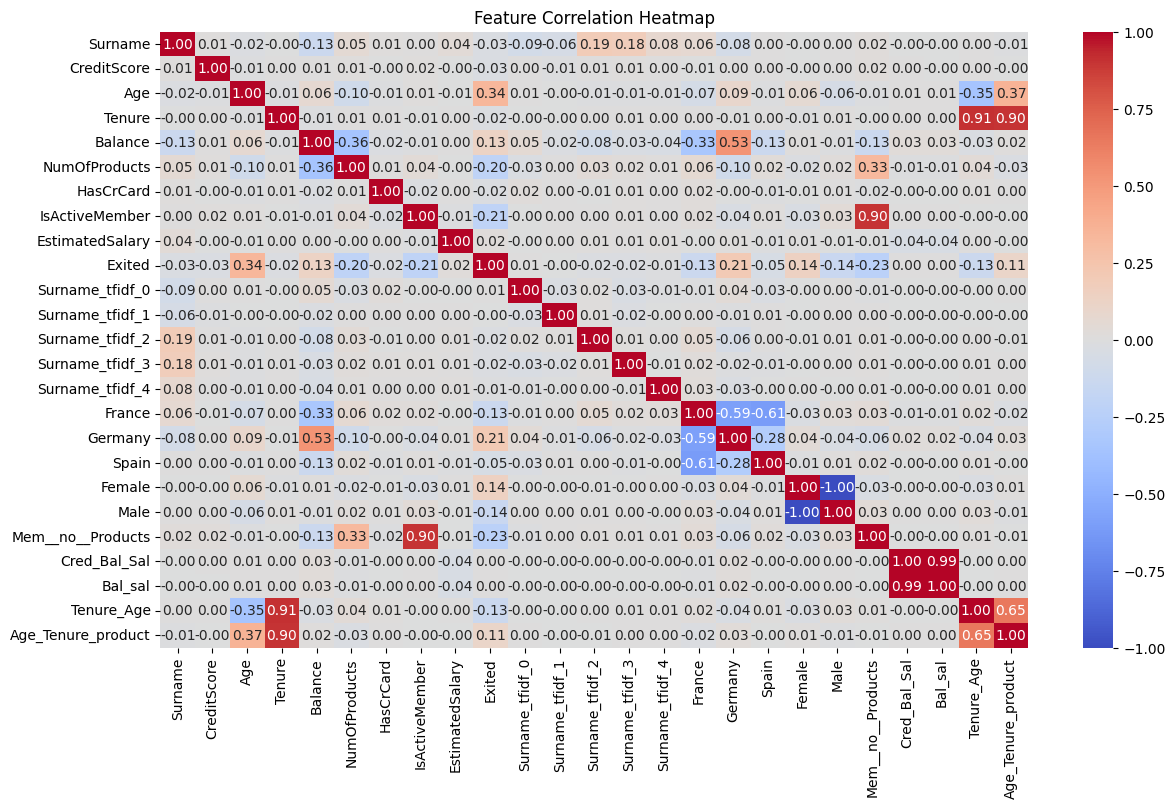

In [6]:
# Create correlation heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [7]:
# Preprocess data
# Drop all columns with less than a 0.05 correlation with Churn
correlation_threshold = 0.05
drop_columns = [col for col in data.columns if abs(data[col].corr(data['Exited'])) < correlation_threshold]
data.drop(columns=drop_columns, inplace=True)
# If two features are highly correlated (>0.8), drop one of them
high_corr_threshold = 0.8
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = set()
for col in upper.columns:
    # Find any feature that is correlated above threshold with this one
    high_corr = [row for row in upper.index if upper.loc[row, col] > high_corr_threshold]
    if high_corr:
        to_drop.add(col)  # Keep the first in the "upper" matrix

data.drop(columns=list(to_drop), inplace=True)

# Now, we have simplified our dataset to only include features that are relevant to predicting churn
data.head()


,Age,Balance,NumOfProducts,IsActiveMember,Exited,France,Germany,Spain,Female,Tenure_Age,Age_Tenure_product
0,33.0,0.00,2.0,0,0,1,0,0,0,0.090909,99.0
1,33.0,0.00,2.0,1,0,1,0,0,0,0.030303,33.0
2,40.0,0.00,2.0,0,0,1,0,0,0,0.250000,400.0
3,34.0,148882.54,1.0,1,0,1,0,0,0,0.058824,68.0
4,33.0,0.00,2.0,1,0,0,0,1,0,0.151515,165.0


In [8]:
# Split data into features and target
X = data.drop(columns=['Exited'])
y = data['Exited']

# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

# Create and train the Random Forest model
rf_model = RandomForest(n_estimators=15, max_depth=2, max_features=8)
rf_model.fit(X_train.values, y_train.values)

# accuracy on training set
train_predictions = rf_model.predict(X_train.values)
train_accuracy = accuracy_score(y_train.values, train_predictions)
print(f"RF Training Accuracy: {train_accuracy:.4f}")
# accuracy on test set
test_predictions = rf_model.predict(X_test.values)
test_accuracy = accuracy_score(y_test.values, test_predictions)
print(f"RF Test Accuracy: {test_accuracy:.4f}")


# Comparso to simple decision tree
dt_model = DecisionTree(max_depth=2)
dt_model.fit(X_train.values, y_train.values)
# accuracy on training set
train_predictions_dt = dt_model.predict(X_train.values)
train_accuracy_dt = accuracy_score(y_train.values, train_predictions_dt)
print(f"Decision Tree Training Accuracy: {train_accuracy_dt:.4f}")
# accuracy on test set
test_predictions_dt = dt_model.predict(X_test.values)
test_accuracy_dt = accuracy_score(y_test.values, test_predictions_dt)
print(f"Decision Tree Test Accuracy: {test_accuracy_dt:.4f}")

Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
Decision Tree built successfully.
RF Training Accuracy: 0.8260
RF Test Accuracy: 0.8242
Decision Tree built successfully.
Decision Tree Training Accuracy: 0.8260
Decision Tree Test Accuracy: 0.8242


The decision tree and RF algorithms performed nearly identically. Overall, solid performance with about 82% accuracy and overfitting appears negligeable.

In [15]:
# Let's compare to Sklearn's Random Forest
sklearn_rf = RandomForestClassifier(n_estimators=15, max_depth=2, max_features=8, random_state=42)
sklearn_rf.fit(X_train, y_train)
# accuracy on training set
sklearn_train_predictions = sklearn_rf.predict(X_train)
sklearn_train_accuracy = accuracy_score(y_train, sklearn_train_predictions)
print(f"Sklearn RF Training Accuracy: {sklearn_train_accuracy:.4f}")
# accuracy on test set
sklearn_test_predictions = sklearn_rf.predict(X_test)
sklearn_test_accuracy = accuracy_score(y_test, sklearn_test_predictions)
print(f"Sklearn RF Test Accuracy: {sklearn_test_accuracy:.4f}")

Sklearn RF Training Accuracy: 0.8260
Sklearn RF Test Accuracy: 0.8242


Sklearn has same results. Let's look at a confusion matrix and ROC curve for further analysis.

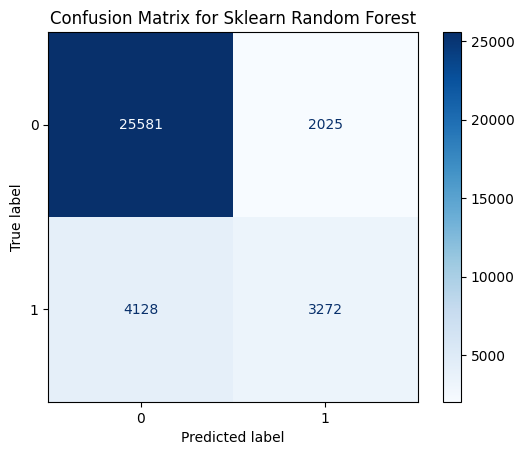

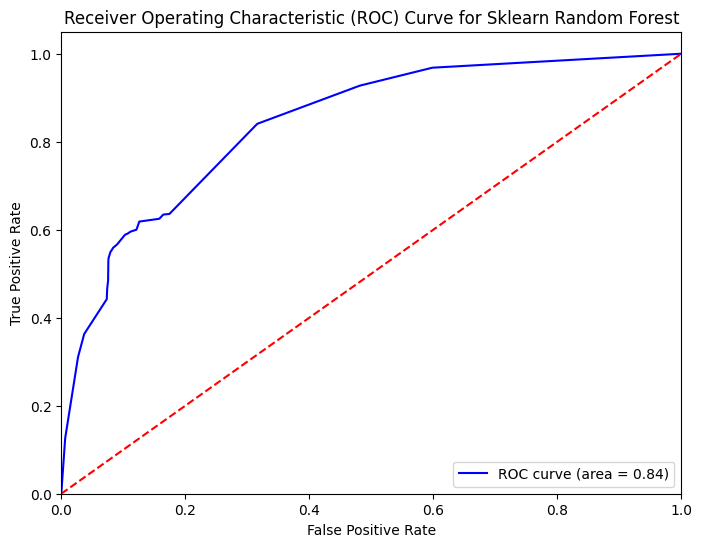

In [16]:
# Confusion matrix and classification report for Sklearn RF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
cm = confusion_matrix(y_test, sklearn_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sklearn_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sklearn Random Forest')
plt.show()

# ROC curve for Sklearn RF
fpr, tpr, thresholds = roc_curve(y_test, sklearn_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Sklearn Random Forest')
plt.legend(loc='lower right')
plt.show()

Overall, it performs well. If we compare these results to the PCA-reduced logistic regression model from `pca_from_scratch.ipynb`, it performs slightly better and appears to capture the churned individuals more frequently (i.e. higher recall).

## Comparison with Gradient Boosting

In [17]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=15, max_depth=2, random_state=42)
gb_model.fit(X_train, y_train)
# accuracy on training set
gb_train_predictions = gb_model.predict(X_train)
gb_train_accuracy = accuracy_score(y_train, gb_train_predictions)
print(f"Gradient Boosting Training Accuracy: {gb_train_accuracy:.4f}")
# accuracy on test set
gb_test_predictions = gb_model.predict(X_test)
gb_test_accuracy = accuracy_score(y_test, gb_test_predictions)
print(f"Gradient Boosting Test Accuracy: {gb_test_accuracy:.4f}")

Gradient Boosting Training Accuracy: 0.8457
Gradient Boosting Test Accuracy: 0.8461


Gradient Boosting outperforms with the same parameters. This is frequently the case as the trees are trained sequentially prioritizing previous errors.

Gradient Boosting Deep Training Accuracy: 0.8661
Gradient Boosting Deep Test Accuracy: 0.8653


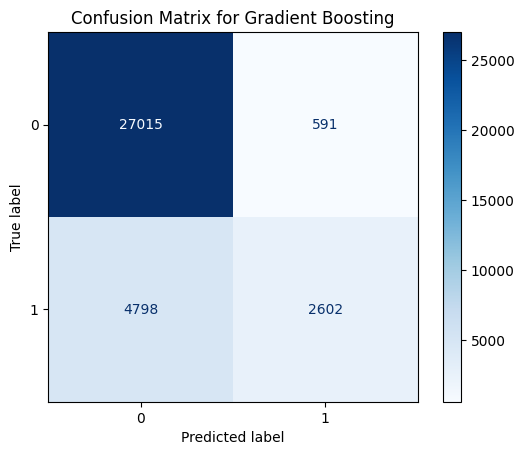

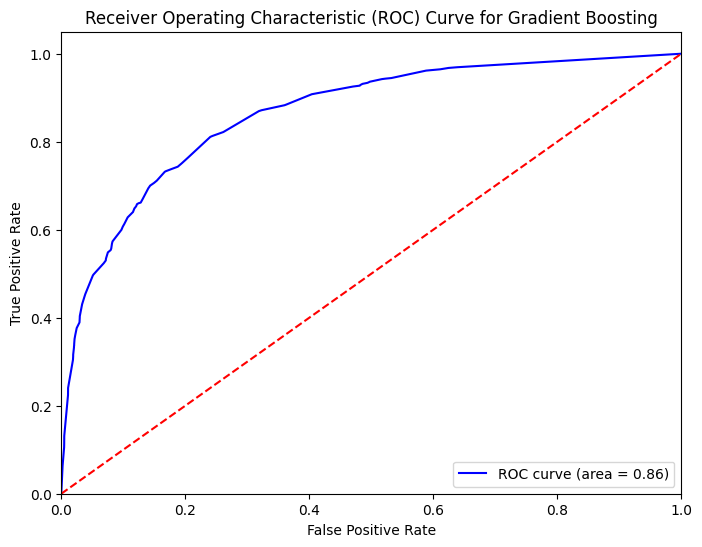

              precision    recall  f1-score   support

 Not Churned       0.89      0.95      0.92     27606
     Churned       0.75      0.55      0.63      7400

    accuracy                           0.87     35006
   macro avg       0.82      0.75      0.78     35006
weighted avg       0.86      0.87      0.86     35006



In [21]:
# As one final check, let's make the trees deeper and grow more of them for GBM
gb_model_deep = GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42)
gb_model_deep.fit(X_train, y_train)
# accuracy on training set
gb_deep_train_predictions = gb_model_deep.predict(X_train)
gb_deep_train_accuracy = accuracy_score(y_train, gb_deep_train_predictions)
print(f"Gradient Boosting Deep Training Accuracy: {gb_deep_train_accuracy:.4f}")
# accuracy on test set
gb_deep_test_predictions = gb_model_deep.predict(X_test)
gb_deep_test_accuracy = accuracy_score(y_test, gb_deep_test_predictions)
print(f"Gradient Boosting Deep Test Accuracy: {gb_deep_test_accuracy:.4f}")

# Confusion matrix and classification report for Gradient Boosting
cm_gb = confusion_matrix(y_test, gb_test_predictions)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb_model.classes_)
disp_gb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()  

# ROC curve for Gradient Boosting
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print(classification_report(y_test, gb_deep_test_predictions, target_names=['Not Churned', 'Churned']))

This is our best result, but the model has difficulty in predicting the minority class (even more so than previous models). We would have to weigh if the increase in accuracy is worth this change.

#### Feature Importance
- A noticeable advantage of using a tree-based model is it's inherent feature importance, which can be determined by a feature's number of splits and the expected gain from the splits.

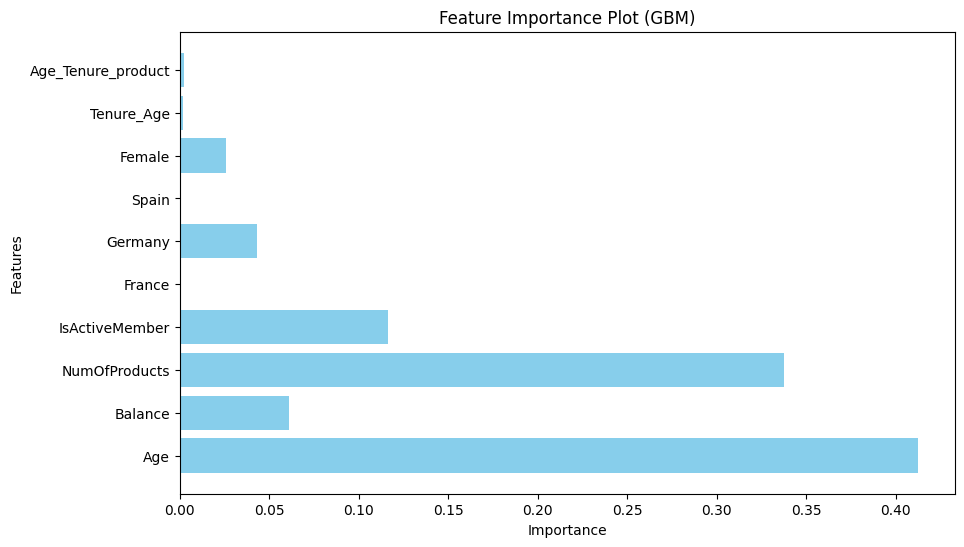

In [20]:
# Feature importance plot of GBM

feature_importances = gb_model_deep.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame with column names

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot (GBM)')
plt.show()

The feature importance plot reaffirms what we discovered in EDA where Age and Number of Products contribute significantly in predicting churn rate.